In [1]:
import pandas as pd
import glob, os
from nltk import word_tokenize, sent_tokenize
from konlpy.tag import Twitter
import nltk
import string
import numpy as np
import sys  

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Common_Module")
    
import CMNLP as CMNLP
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

path = r'C:\\Users\\HANA\\PycharmProjects\\HANATOUR\\NLP\\TEXT_Example\\topic'
all_files = glob.glob(os.path.join(path,"*.data"))
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]

    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
# print(document_df.head())

from sklearn.feature_extraction.text import TfidfVectorizer

tfodf_vect = TfidfVectorizer(tokenizer=CMNLP.LemNormalize, stop_words='english', ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfodf_vect.fit_transform(document_df['opinion_text'])
# print(feature_vect)

from sklearn.cluster import KMeans

km_cluster = KMeans(n_clusters=5, max_iter=1000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

document_df['cluster_label'] = cluster_label

# print(document_df.head())
# print(document_df[document_df['cluster_label']==0].sort_values(by='filename'))
# print(document_df[document_df['cluster_label']==1].sort_values(by='filename'))
# print(document_df[document_df['cluster_label']==2].sort_values(by='filename'))
# print(document_df[document_df['cluster_label']==3].sort_values(by='filename'))
# print(document_df[document_df['cluster_label']==4].sort_values(by='filename'))

cluster_centers = km_cluster.cluster_centers_
print('cluster centers shape :', cluster_centers.shape)
print(cluster_centers)

feature_names = tfodf_vect.get_feature_names()
cluster_details = CMNLP.get_cluster_details(cluster_model=km_cluster, cluster_data=document_df, feature_names=feature_names, clusters_num=5, top_n_features=10)
CMNLP.print_cluster_details(cluster_details)

c:\users\hana\pycharmprojects\hanatour\venv\lib\site-packages\sklearn\feature_extraction\text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


cluster centers shape : (5, 4611)
[[0.00857792 0.         0.         ... 0.01710556 0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]
 [0.         0.00102835 0.         ... 0.         0.         0.        ]
 [0.01282853 0.         0.         ... 0.         0.         0.        ]
 [0.00881133 0.         0.         ... 0.00331061 0.         0.        ]]
####### Cluster 0
Top features: ['direction', 'map', 'screen', 'speed limit', 'speed', 'accurate', 'satellite', 'transmission', 'limit', 'update']
filename : ['accuracy_garmin_nuvi_255W_gps', 'directions_garmin_nuvi_255W_gps', 'display_garmin_nuvi_255W_gps', 'satellite_garmin_nuvi_255W_gps', 'screen_garmin_nuvi_255W_gps', 'speed_garmin_nuvi_255W_gps', 'transmission_toyota_camry_2007']
####### Cluster 1
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
filename : ['bathroom_bestwestern_hotel_sfo', 'food_holiday_inn_london', 'food_sw

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

#cluster_label=1인 데이터는 호텔로 군집화된 데이터님. DataFrame에서 해당 인덱스를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print(hotel_indexes)

#호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 차일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]['filename']]
print(comparison_docname)

similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

Int64Index([1, 13, 14, 15, 20, 21, 24, 28, 30, 31, 32, 38, 39, 40, 45, 46], dtype='int64')


IndexError: invalid index to scalar variable.

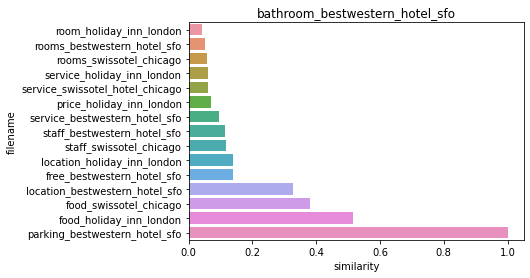

In [9]:
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

#첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:,1:]

#유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

#유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1)[::-1])
hotel_1_sim_value = hotel_1_sim_value[1:]

#유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)
plt.show()